In [84]:
%run /home/user/besos/Matthias/tools/imports.ipynb
from tensorflow.keras import regularizers
def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(2)]
        X = standardization[0].fit_transform(X)
        y = standardization[1].fit_transform(y)
    else:
        X = standardization[0].transform(X)
        y = standardization[1].transform(y)

    return X, y, standardization

def get_model_4(n_params=14, n_neurons=256, alpha=0.001):
    inputs = Input(shape=(n_params))
    hidden = Dense(n_neurons, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(inputs)
    outputs = Dense(1, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(alpha))(hidden)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='mse')
    model.summary()
    
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)
ann = KerasRegressor(build_fn=get_model_4, epochs=800, verbose=0)

In [89]:
X, y = read_samples('CAN', param_set=23, limit=10000, output_meter = 'DistrictHeating:Facility')
X, y, standardization = preprocess(pd.concat([X.iloc[:,:13], X.iloc[:,17]], axis=1), y)
ann.fit(X, y, callbacks=[early_stopping], validation_split=0.2)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               3840      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [90]:
param_set=23
def evaluation_func(ind):
    return ((ann.predict([ind])[0],),())
problem = EPProblem(parameters[param_set][:-2], parameters[param_set][-1])
ann_sr = EvaluatorSR(evaluation_func, problem)
len(problem.inputs)

13

In [91]:
from SALib.sample import saltelli as ssampling
from SALib.analyze import sobol as sanalysis

names =[parameters[param_set][i].name for i in range(len(parameters[param_set])-2)]
names.append('HDD18')
bounds=[[parameters[param_set][i].value_descriptor.min, parameters[param_set][i].value_descriptor.max] for i in range(len(parameters[param_set])-2)]
bounds.append([2300, 13200])

problem_sobol = {
    'num_vars': len(parameters[param_set]) - 2 + 1,
    'num_inputs': len(parameters[param_set]) - 2 + 1,
    'names': names,
    'bounds': bounds}
X_sobol = np.round(ssampling.sample(problem_sobol, N=10000, calc_second_order = True), decimals=8)
X_sobol = pd.DataFrame(data=X_sobol,columns=names)

print(f'This Sobol analysis will require {len(X_sobol)} design evaulations for the analysis.')

This Sobol analysis will require 300000 design evaulations for the analysis.


In [92]:
%%time
y_sobol = pd.DataFrame(ann.predict(standardization[0].transform(X_sobol)))
# y_sobol = y_sobol.values.ravel()

CPU times: user 3.67 s, sys: 808 ms, total: 4.48 s
Wall time: 3.65 s


In [93]:
y_sobol
y_sobol_trans = standardization[1].inverse_transform(y_sobol)
y_sobol_trans.min()*1e-11

-2.97410822144

In [94]:
%%time
problem = {
    'num_vars': len(parameters[param_set])-2+1,
    'num_inputs': len(parameters[param_set])-2+1,
    'names': names,
    'bounds': bounds}
# Si = sanalysis.analyze(problem, y_sobol.values.ravel(), conf_level=0.95, print_to_console=False, parallel=True, n_processors=4)
Si = sanalysis.analyze(problem, y_sobol_trans.reshape(300000), conf_level=0.99, print_to_console=False, parallel=True, n_processors=4)

CPU times: user 68.1 ms, sys: 92.5 ms, total: 161 ms
Wall time: 2.62 s


In [95]:
df = pd.DataFrame(Si['S1'] * 100, columns=['First order sensitivity'], index=names)
df['1. order sensitivity confidence'] = Si['S1_conf'] * 100
df['Total sensitivity'] = Si['ST'] * 100
df['Total sensitivity confidence'] = Si['ST_conf'] * 100
# df.sort_values('First order sensitivity', ascending=False)
df

First order sensitivity  \
North Axis                                   0.014285   
Wall Insulation Conductivity                 3.487902   
Wall Insulation Thickness                    1.154403   
Window Solar Transmittance                   0.004633   
Window Conductivity                          0.834184   
Wall Solar Absorptance                       0.000613   
Heating Setpoint                             0.660205   
Cooling Setpoint                            -0.002999   
Equipment Gains                              0.008977   
Lights Gains                                -0.000198   
Ventilation Flow Rate                        0.109912   
Infiltration Flow Rate                       7.321409   
Window to Wall Ratio                         5.249429   
HDD18                                       77.420999   

                              1. order sensitivity confidence  \
North Axis                                           0.055846   
Wall Insulation Conductivity                         0.858189   
Wall Insulation Thickness                            0.499390   
Window Solar Transmittance                           0.021536   
Window Conductivity                                  0.388694   
Wall Solar Absorptance                               0.026799   
Heating Setpoint                                     0.306491   
Cooling Setpoint                                     0.019110   
Equipment Gains                                      0.054288   
Lights Gains                                         0.034689   
Ventilation Flow Rate                                0.115626   
Infiltration Flow Rate                               1.055867   
Window to Wall Ratio                                 0.838673   
HDD18                                                2.514364   

                              Total sensitivity  Total sensitivity confidence  
North Axis                             0.026090                      0.001403  
Wall Insulation Conductivity           4.421364                      0.219349  
Wall Insulation Thickness              1.528201                      0.084268  
Window Solar Transmittance             0.004024                      0.000271  
Window Conductivity                    1.090694                      0.063832  
Wall Solar Absorptance                 0.005533                      0.000336  
Heating Setpoint                       0.685151                      0.029577  
Cooling Setpoint                       0.003037                      0.000193  
Equipment Gains                        0.026824                      0.001427  
Lights Gains                           0.009114                      0.000483  
Ventilation Flow Rate                  0.130952                      0.006044  
Infiltration Flow Rate                 8.550767                      0.370942  
Window to Wall Ratio                   6.334619                      0.323233  
HDD18                                 80.715672                      2.640500

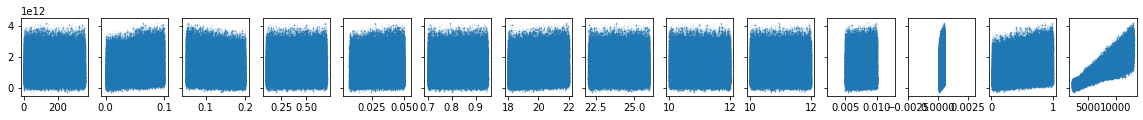

In [96]:
num_params = len(parameters[param_set])-2+1
fig, ax = plt.subplots(nrows=1, ncols=num_params, figsize=(20,20/num_params), sharey=True)

for i, col in zip(range(num_params), ax):
    col.scatter(X_sobol.iloc[:,i], y_sobol_trans, s=0.1, alpha=0.2)